Auteur : Nicolas Quéquet

Dans ce notebook, nous allons nettoyer le csv owid-co2-continents : émissions de GES par continents.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')

owid_continents = pd.read_csv('drive/MyDrive/Projet Mar25 DA - DataScientest/WIP CSV/owid-co2-continents.csv')
owid_continents.head()


Mounted at /content/drive


,year,country,population,cement_co2,cement_co2_per_capita,co2,co2 (GCP),co2_growth_abs,co2_growth_prct,co2_including_luc,...,share_global_other_co2,share_of_temperature_change_from_ghg,temperature_change_from_ch4,temperature_change_from_co2,temperature_change_from_ghg,temperature_change_from_n2o,total_ghg,total_ghg_excluding_lucf,trade_co2,trade_co2_share
0,1750,Africa,80349715.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1751,Africa,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1752,Africa,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1753,Africa,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1754,Africa,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
def print_nan_per_countries(df):
  '''
  Cette fonction affiche le nombre de nan par "country"
  '''
  #comptage des NaN par continent
  for c in df['country'].unique():
    print("=================", c)
    df_tmp = df[df['country']==c]
    cols_nan = df_tmp.columns[df_tmp.isna().any(axis = 0)]
    nan_counts = df_tmp[cols_nan].isna().sum()
    print(nan_counts)
    print("nb lignes =", len(df_tmp))

In [ ]:
#pour les émissions absolues, on remplace les NaN par 0 car ça veut dire qu'on a pas les données avant une certaine année
def fillna_co2_emissions(df):
  '''
  Cette fonction remplace les NaN des émissions de co2 par 0
  '''
  cols = []
  for c in df.columns:
    if 'co2' in c and 'cumulative' not in c and 'global' not in c and 'per_capita' not in c and 'growth' not in c:
      cols.append(c)

  df.loc[:, cols] = df[cols].fillna(0)
  return df

In [ ]:
def interpolate_population(df) :
  '''
  Cette fonction remplit les NaN de population par une interpolation quadratique
  '''
  result = df.copy()
  for country in result['country'].unique():
    result.loc[result['country']==country, 'population'] = result.loc[result['country']==country, 'population'].interpolate(method='spline',order=2)
  return result

In [ ]:
def interpolate_gdp(df) :
  '''
  Cette fonction remplit les NaN de gdp par une interpolation quadratique
  '''
  result = df.copy()
  for country in result['country'].unique():
    result.loc[result['country']==country, 'gdp'] = result.loc[result['country']==country, 'gdp'].interpolate(method='spline',order=2)
  return result

In [ ]:
def compute_per_capita_cols(df):
  '''
  Cette fonction calcule les colonnes "per_capita" en divisant par la population
  '''
  #on remplace les Na des colonnes "per_capita" en divisant par la population
  cols = ['year','population']
  for c in df.columns:
    suffix = '_per_capita'
    if suffix in c:
      base = c.replace(suffix,'')
      if base in df.columns:
        df.loc[:,c] = df[c].fillna(10**6 * df[base]/df['population'])
        cols.append(base)
        cols.append(c)
  #cas particuliers où les colonnes de base ne sont pas juste prefix dans prefix_per_capita :
  df.loc[:,'ghg_excluding_lucf_per_capita'] = df['ghg_excluding_lucf_per_capita'].fillna(10**6 * df['total_ghg_excluding_lucf']/df['population'])
  df.loc[:,'ghg_per_capita'] = df['ghg_per_capita'].fillna(10**6 * df['total_ghg']/df['population'])
  df.loc[:,'other_co2_per_capita'] = df['other_co2_per_capita'].fillna(10**6 * df['other_industry_co2']/df['population'])
  return df

In [ ]:
def compute_per_gdp_cols(df):
  '''
  Cette fonction calcule les colonnes "per_gdp" en divisant par gdp
  '''
  #on remplace les Na des colonnes "per_gdp" en divisant par gdp
  for c in df.columns:
    suffix = '_per_gdp'
    if suffix in c:
      base = c.replace(suffix,'')
      if base in df.columns:
        df.loc[:,c] = df[c].fillna(10**9 * df[base]/df['gdp'])
        cols.append(c)
      else:
        print("could not find column :", base)
  print("columns handled =", cols)
  return df

In [ ]:
def reset_cumul(df):
  '''
    Recalcule les cumuls en remettant la première ligne à la valeur des émissions
    et remplace la première valeur NaN d'un cumul par la première valeur de son émission (ou 0 si émission NaN)
  '''
  cumul_cols = []
  for c in df.columns:
    if 'cumulative' in c and 'share' not in c:
      cumul_cols.append(c)

  cols = []
  #on recalcule les colonnes cumulatives
  for country in df['country'].unique():
    df_tmp = df[df['country']==country]
    for col in cumul_cols:
      prefix = col.replace('cumulative_','')

      if 'luc' in prefix:
        prefix = 'land_use_change_co2'
      elif 'other' in prefix:
        prefix = 'other_industry_co2'

      if prefix in df_tmp.columns:
        if col not in cols:
          cols.append(col)
        if prefix not in cols:
          cols.append(prefix)

        first_prefix = df_tmp[prefix].iloc[0]
        if np.isnan(first_prefix):
          first_prefix = 0

        first_cumul = df_tmp[col].iloc[0]
        if np.isnan(first_cumul):
          first_cumul = first_prefix

        df_tmp.loc[:,col] = df_tmp.apply(lambda row : (0 if pd.isna(row[prefix]) else row[prefix]) if pd.isna(row[col]) else (row[col] - first_cumul + first_prefix), axis=1)
      else:
        print('could not fill column :', col)
    df.loc[df['country']==country, cols] = df_tmp[cols]
  return df

In [ ]:
def compute_share(df, df_world) :
  '''
  Calcule les colonnes share par rapport aux données mondiales
  '''
  cols_share = []
  for c in df.columns:
    if 'share' in c:
      cols_share.append(c)
  df_world_slice = df_world.loc[(df_world['year'] >= min(df['year'])) & (df_world['year'] <= max(df['year']))].reset_index()
  for country in df['country'].unique():
    df_tmp = df[df['country']==country].reset_index()
    for col in cols_share:
      base = col.replace('share_global_','')
      base = base.replace('share_of_','')
      base = base.replace('_share','')
      if base == 'other_co2':
        base = 'other_industry_co2'
      elif base == 'luc_co2':
        base = 'land_use_change_co2'

      if base in df_tmp.columns and base in df_world_slice.columns:
        df_tmp.loc[:,col] = np.where(df_world_slice[base] == 0, 0, df_tmp[base] / df_world_slice[base] * 100)
      else :
        print("could not compute columnn :",col)
        print(base, " in df :", base in df_tmp.columns)
        print(base, " in df_world :", base in df_world_slice.columns)
    df_tmp = df_tmp.set_index('index')
    df.loc[df['country']==country, cols_share] = df_tmp[cols_share]

  return df

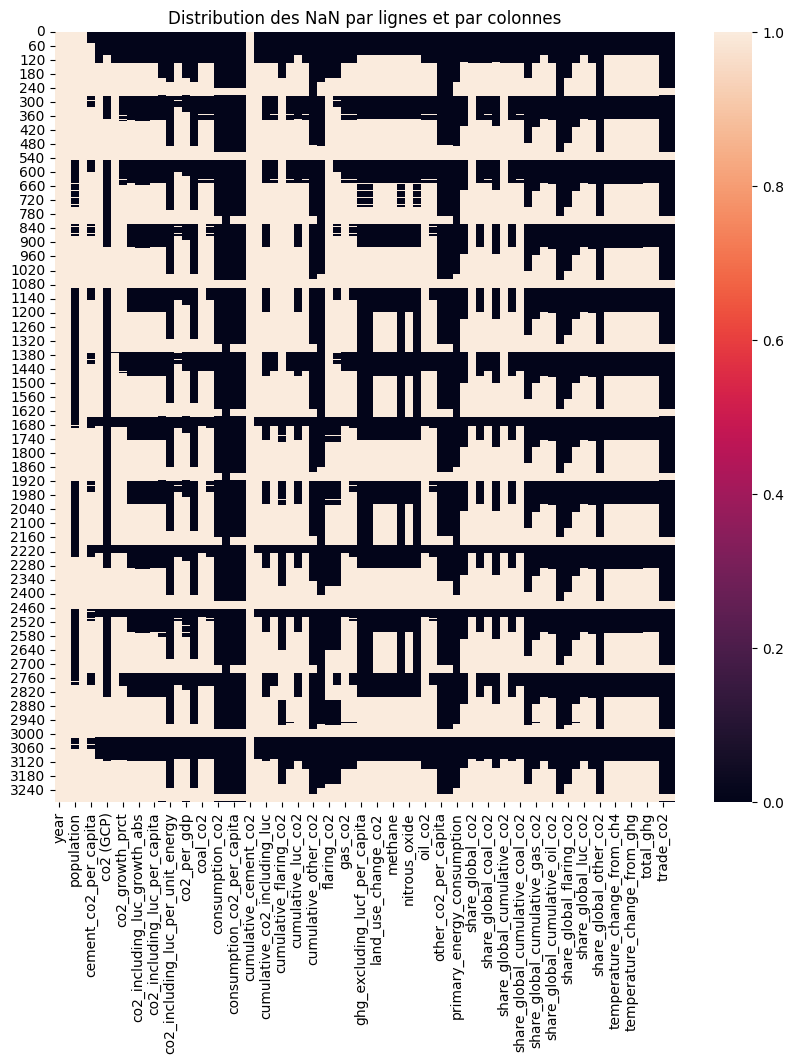

In [ ]:
#Regardons la distribution des NaN
plt.figure(figsize=(10,10))
plt.title("Distribution des NaN par lignes et par colonnes")
sns.heatmap(owid_continents.notna());

In [ ]:
#Regardons ce que nous avons en modalités de country
owid_continents['country'].unique()

array(['Africa', 'Asia', 'Asia (excl. China and India)', 'Europe',
       'Europe (excl. EU-27)', 'Europe (excl. EU-28)',
       'European Union (27)', 'European Union (28)', 'North America',
       'North America (excl. USA)', 'Oceania', 'South America'],
      dtype=object)

In [ ]:
#Analysons les périodes de données des country liés à l'Europe
country_eu = []
for c in owid_continents['country'].unique():
  if 'Europe' in c:
    print("=====================", c)
    df_tmp = owid_continents[owid_continents['country']==c]
    print(f"Year period : {min(df_tmp['year'])} -  {max(df_tmp['year'])}")
    country_eu.append(c)

#Regardons plus en détail ce que nous avons comme données pour les countrys liés à l'Europe sur une courte plage de temps
owid_continents.loc[(owid_continents['country'].isin(country_eu)) & (owid_continents['year']>1980) & (owid_continents['year'] < 1985)].head(60)

===================== Europe
Year period : 1750 -  2023
===================== Europe (excl. EU-27)
Year period : 1750 -  2023
===================== Europe (excl. EU-28)
Year period : 1750 -  2023
===================== European Union (27)
Year period : 1750 -  2023
===================== European Union (28)
Year period : 1750 -  2023


,year,country,population,cement_co2,cement_co2_per_capita,co2,co2 (GCP),co2_growth_abs,co2_growth_prct,co2_including_luc,...,share_global_other_co2,share_of_temperature_change_from_ghg,temperature_change_from_ch4,temperature_change_from_co2,temperature_change_from_ghg,temperature_change_from_n2o,total_ghg,total_ghg_excluding_lucf,trade_co2,trade_co2_share
1053,1981,Europe,698282872.0,167.641,0.240,7468.539,7468.538,-281.640,-3.634,7735.384,...,NaN,28.822,0.059,0.169,0.239,0.011,9990.085,8758.298,NaN,NaN
1054,1982,Europe,701148276.0,163.106,0.233,7408.562,7408.562,-59.976,-0.803,7609.480,...,NaN,28.796,0.060,0.172,0.244,0.012,9881.190,8704.690,NaN,NaN
1055,1983,Europe,703986058.0,163.106,0.232,7415.053,7415.053,6.491,0.088,7666.637,...,NaN,28.766,0.060,0.176,0.248,0.012,9933.633,8712.942,NaN,NaN
1056,1984,Europe,706830247.0,157.478,0.223,7466.038,7466.038,50.985,0.688,7720.284,...,NaN,28.715,0.061,0.179,0.252,0.012,9980.424,8738.880,NaN,NaN
1327,1981,Europe (excl. EU-27),NaN,58.020,0.200,3603.618,NaN,-67.543,-1.840,4032.148,...,NaN,15.470,0.029,0.094,0.128,0.005,5034.670,4232.125,NaN,NaN
1328,1982,Europe (excl. EU-27),NaN,56.367,0.194,3635.600,NaN,31.981,0.887,3995.376,...,NaN,15.438,0.030,0.096,0.131,0.005,5005.870,4265.636,NaN,NaN
1329,1983,Europe (excl. EU-27),NaN,57.632,0.197,3684.997,NaN,49.398,1.359,4071.328,...,NaN,15.411,0.030,0.097,0.133,0.005,5090.403,4315.518,NaN,NaN
1330,1984,Europe (excl. EU-27),NaN,57.848,0.197,3700.865,NaN,15.867,0.431,4097.254,...,NaN,15.371,0.030,0.099,0.135,0.006,5097.093,4311.859,NaN,NaN
1601,1981,Europe (excl. EU-28),NaN,51.715,0.222,3043.064,NaN,-49.062,-1.587,3469.067,...,NaN,11.522,0.023,0.068,0.096,0.004,4258.533,3521.827,NaN,NaN
1602,1982,Europe (excl. EU-28),NaN,49.945,0.213,3087.359,NaN,44.295,1.456,3445.262,...,NaN,11.534,0.024,0.070,0.098,0.004,4244.807,3571.990,NaN,NaN


In [ ]:
#Analysons en détail 3 countrys liés à l'europe sur une année
country_eu = ["Europe", "Europe (excl. EU-27)", "European Union (27)"]

df_tmp = owid_continents.loc[(owid_continents['country'].isin(country_eu)) & (owid_continents['year']==2010)].head(10)

df_tmp



,year,country,population,cement_co2,cement_co2_per_capita,co2,co2 (GCP),co2_growth_abs,co2_growth_prct,co2_including_luc,...,share_global_other_co2,share_of_temperature_change_from_ghg,temperature_change_from_ch4,temperature_change_from_co2,temperature_change_from_ghg,temperature_change_from_n2o,total_ghg,total_ghg_excluding_lucf,trade_co2,trade_co2_share
1082,2010,Europe,739273391.0,113.756,0.154,6116.594,6116.594,223.691,3.796,6319.022,...,25.234,24.351,0.054,0.258,0.331,0.018,7853.912,7050.157,686.016,11.216
1356,2010,Europe (excl. EU-27),NaN,36.804,0.123,2692.537,NaN,130.185,5.081,3065.355,...,9.673,12.788,0.029,0.136,0.174,0.008,3776.682,3233.026,-184.994,-6.871
1904,2010,European Union (27),440608967.0,76.952,0.175,3424.056,NaN,93.506,2.808,3253.667,...,15.560,11.563,0.025,0.121,0.157,0.010,4077.230,3817.132,871.009,25.438


Concernant les émissions, on remarque globalement que Europe = Europe (excl. EU-27) + European Union (27).
Ce qui est logique : si on prend l'UE des 27 et qu'on y ajoute les pays européens hors UE des 27, on a toute l'Europe.
Pour notre analyse portée sur les continents, nous n'avons pas besoin de cette distinction. Seule l'Europe dans son intégralité nous intéresse ici.

In [ ]:
country_eu = ["Europe", "Europe (excl. EU-28)", "European Union (28)"]

df_tmp = owid_continents.loc[(owid_continents['country'].isin(country_eu)) & (owid_continents['year']==1950)].head(10)

df_tmp

,year,country,population,cement_co2,cement_co2_per_capita,co2,co2 (GCP),co2_growth_abs,co2_growth_prct,co2_including_luc,...,share_global_other_co2,share_of_temperature_change_from_ghg,temperature_change_from_ch4,temperature_change_from_co2,temperature_change_from_ghg,temperature_change_from_n2o,total_ghg,total_ghg_excluding_lucf,trade_co2,trade_co2_share
1022,1950,Europe,549361682.0,32.755,0.060,2383.328,2383.328,117.198,5.172,2873.955,...,NaN,30.210,0.029,0.089,0.123,0.004,4104.645,3011.756,NaN,NaN
1570,1950,Europe (excl. EU-28),NaN,5.258,0.031,604.767,NaN,57.439,10.494,995.459,...,NaN,12.229,0.013,0.035,0.050,0.002,1455.445,836.041,NaN,NaN
2118,1950,European Union (28),NaN,27.497,0.073,1778.561,NaN,59.759,3.477,1878.496,...,NaN,17.981,0.017,0.054,0.073,0.003,2649.199,2175.715,NaN,NaN


Constatant que Europe = Europe (excl. EU-28) + European Union (28),
et qu'il en va de même pour l'Europe des 27,
et ne souhaitant nous focaliser que sur le continent Europe sans aller dans le détail de l'UE, nous pouvons supprimer les countries faisant référence à l'Europe mais qui ne sont pas "Europe".

In [ ]:
#suppression des countries Union Europeenne et Europe excluant UE 27 ou 28 ; pour ne garder que Europe
country_eu = []
for c in owid_continents['country'].unique():
  if 'Europe' in c:
    df_tmp = owid_continents[owid_continents['country']==c]
    country_eu.append(c)

country_eu.remove('Europe')

owid_continents = owid_continents[~owid_continents['country'].isin(country_eu)]

owid_continents['country'].unique()

array(['Africa', 'Asia', 'Asia (excl. China and India)', 'Europe',
       'North America', 'North America (excl. USA)', 'Oceania',
       'South America'], dtype=object)

In [ ]:
#suppression des countries "excl."

country_excl = []
for c in owid_continents['country'].unique():
  if 'excl.' in c:
    df_tmp = owid_continents[owid_continents['country']==c]
    country_excl.append(c)

owid_continents = owid_continents[~owid_continents['country'].isin(country_excl)]

owid_continents['country'].unique()

array(['Africa', 'Asia', 'Europe', 'North America', 'Oceania',
       'South America'], dtype=object)

#Désormais on a bien que les continents

Calculons la population manquante et les colonnes _per_capita

In [ ]:
#Calcul population manquante
owid_continents.loc[owid_continents['country'] == 'Africa', 'population'] = owid_continents.loc[owid_continents['country'] == 'Africa', 'population'].interpolate(method='spline',order=2)
owid_continents.loc[owid_continents['country'] == 'Asia', 'population'] = owid_continents.loc[owid_continents['country'] == 'Asia', 'population'].interpolate(method='spline',order=2)
owid_continents.loc[owid_continents['country'] == 'Europe', 'population'] = owid_continents.loc[owid_continents['country'] == 'Europe', 'population'].interpolate(method='spline',order=2)
owid_continents.loc[owid_continents['country'] == 'North America', 'population'] = owid_continents.loc[owid_continents['country'] == 'North America', 'population'].interpolate(method='spline',order=2)
owid_continents.loc[owid_continents['country'] == 'Oceania', 'population'] = owid_continents.loc[owid_continents['country'] == 'Oceania', 'population'].interpolate(method='spline',order=2)
owid_continents.loc[owid_continents['country'] == 'South America', 'population'] = owid_continents.loc[owid_continents['country'] == 'South America', 'population'].interpolate(method='spline',order=2)



/usr/local/lib/python3.11/dist-packages/pandas/core/missing.py:604: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  terp = interpolate.UnivariateSpline(x, y, k=order, **kwargs)


In [ ]:
#calcul des colonnes per_capita
owid_continents = compute_per_capita_cols(owid_continents)


In [ ]:
first_year = owid_continents.loc[(owid_continents['country']=='Africa') & (owid_continents["cement_co2"].notna()), ['year']].head(1)
print("year = ", first_year['year'][0])

year =  1750


In [ ]:
#Affichage par continent, des groupes de colonnes ayant des valeurs à partir de la même année
for c in owid_continents['country'].unique():
  dic_year = {}
  print(c)
  owid_c = owid_continents[owid_continents['country']==c]
  for col in owid_c.columns[owid_c.isna().any(axis = 0)]:
    first_line = owid_c.loc[owid_c[col].notna(), ['year']].head(1).reset_index()
    if first_line.empty:
      continue
    first_year = first_line['year'][0]
    if first_year in dic_year:
      dic_year[first_year].append(col)
    else:
      dic_year[first_year] = [col]
  for y, cols in dic_year.items():
    print(c, "---", y, ":", cols)




Africa
Africa --- 1884 : ['co2', 'co2_including_luc', 'co2_including_luc_per_capita', 'co2_per_capita', 'coal_co2', 'coal_co2_per_capita', 'cumulative_co2', 'cumulative_co2_including_luc', 'cumulative_coal_co2', 'cumulative_gas_co2', 'cumulative_oil_co2', 'gas_co2', 'gas_co2_per_capita', 'oil_co2', 'oil_co2_per_capita', 'share_global_co2', 'share_global_co2_including_luc', 'share_global_coal_co2', 'share_global_cumulative_co2', 'share_global_cumulative_co2_including_luc', 'share_global_cumulative_coal_co2', 'share_global_cumulative_gas_co2', 'share_global_cumulative_oil_co2', 'share_global_gas_co2', 'share_global_oil_co2']
Africa --- 1850 : ['co2 (GCP)', 'cumulative_luc_co2', 'ghg_excluding_lucf_per_capita', 'ghg_per_capita', 'land_use_change_co2', 'land_use_change_co2_per_capita', 'methane', 'methane_per_capita', 'nitrous_oxide', 'nitrous_oxide_per_capita', 'share_global_cumulative_luc_co2', 'share_global_luc_co2', 'total_ghg', 'total_ghg_excluding_lucf']
Africa --- 1885 : ['co2_growt

Les colonnes consumption : on les a toutes à partir de 1990.

Les colonnes energy : à partir de 1965.

On commence à avoir des données intéressantes qu'à partir de 1850 ; ce qu'il se passe avant ne nous intéresse pas.



In [ ]:
#suppression des colonnes liées au gdp puisqu'on a pas de gdp pour les continents
col_gdp = []

for c in owid_continents.columns:
  if 'gdp' in c:
    col_gdp.append(c)

owid_continents = owid_continents.drop(columns=col_gdp)

# Création du csv continents energy (à partir de 1965)

In [ ]:
#récupération des colonnes qui nous intéressent
col_energy = ["year", "country", "population", "co2", "co2_including_luc"]

for c in owid_continents.columns:
  if 'energy' in c:
    col_energy.append(c)

col_energy

['year',
 'country',
 'population',
 'co2',
 'co2_including_luc',
 'co2_including_luc_per_unit_energy',
 'co2_per_unit_energy',
 'energy_per_capita',
 'primary_energy_consumption']

In [ ]:
#on garde que les années qui nous intéressent
owid_continents_energy = owid_continents.loc[owid_continents['year']>1965, col_energy]

display(owid_continents_energy)

,year,country,population,co2,co2_including_luc,co2_including_luc_per_unit_energy,co2_per_unit_energy,energy_per_capita,primary_energy_consumption
216,1966,Africa,329252360.0,221.082,1304.675,2.578,0.437,2275.487,750.133
217,1967,Africa,337851070.0,237.045,1342.630,2.650,0.468,2241.349,757.934
218,1968,Africa,346800965.0,257.271,1332.752,2.479,0.479,2307.324,800.596
219,1969,Africa,356032572.0,277.717,1375.873,2.552,0.515,2310.408,822.668
220,1970,Africa,365552194.0,302.406,1421.348,2.450,0.521,2443.656,893.035
...,...,...,...,...,...,...,...,...,...
3283,2019,South America,423548289.0,1084.626,2546.332,0.363,0.155,16460.289,7050.242
3284,2020,South America,426213551.0,979.441,2478.592,0.381,0.151,15154.642,6539.684
3285,2021,South America,428331420.0,1079.731,2816.267,0.402,0.154,16254.437,7058.557
3286,2022,South America,430492814.0,1096.153,2660.583,0.375,0.155,17016.160,7432.943


In [ ]:
#a t-on des nulls ?
owid_continents_energy.isnull().sum(axis = 0)

,0
year,0
country,0
population,0
co2,0
co2_including_luc,0
co2_including_luc_per_unit_energy,0
co2_per_unit_energy,0
energy_per_capita,0
primary_energy_consumption,0


In [ ]:
#creation du csv lié aux énergies
owid_continents_energy.to_csv('drive/MyDrive/Projet Mar25 DA - DataScientest/Cleaned CSV/owid_co2_per_energy_continents.csv', index=False)

In [ ]:
#suppr des colonnes energy pour le df continen
col_energy = []
for c in owid_continents.columns:
  if 'energy' in c:
    col_energy.append(c)

owid_continents = owid_continents.drop(columns=col_energy)

On créé un csv pour les données après 1990 pour les données de consumption

In [ ]:
#recuperation des lignes après 1990
owid_continents_1990 = owid_continents.loc[owid_continents['year']>1990]
#affichage des nan par colonnes par continents
for c in owid_continents_1990['country'].unique():
  print("=================", c)
  df_tmp = owid_continents_1990[owid_continents_1990['country']==c]
  cols_nan = df_tmp.columns[df_tmp.isna().any(axis = 0)]
  nan_counts = df_tmp[cols_nan].isna().sum()
  print(nan_counts)
  print("nb lignes =", len(df_tmp))


================= Africa
consumption_co2                       1
consumption_co2 (GCP)                 1
consumption_co2_per_capita            1
cumulative_other_co2                 33
other_co2_per_capita                 33
other_industry_co2                   33
share_global_cumulative_other_co2    33
share_global_other_co2               33
trade_co2                             1
trade_co2_share                       1
dtype: int64
nb lignes = 33
================= Asia
consumption_co2               1
consumption_co2 (GCP)         1
consumption_co2_per_capita    1
trade_co2                     1
trade_co2_share               1
dtype: int64
nb lignes = 33
================= Europe
consumption_co2               1
consumption_co2 (GCP)         1
consumption_co2_per_capita    1
trade_co2                     1
trade_co2_share               1
dtype: int64
nb lignes = 33
================= North America
consumption_co2               1
consumption_co2 (GCP)         1
consumption_co2_per_capita 

In [ ]:
#regardons d'où viennent les NaN pour l'europe
df_tmp = owid_continents_1990[owid_continents_1990['country']=="Europe"]
df_tmp[df_tmp.isna().any(axis = 1)]

,year,country,population,cement_co2,cement_co2_per_capita,co2,co2 (GCP),co2_growth_abs,co2_growth_prct,co2_including_luc,...,share_global_other_co2,share_of_temperature_change_from_ghg,temperature_change_from_ch4,temperature_change_from_co2,temperature_change_from_ghg,temperature_change_from_n2o,total_ghg,total_ghg_excluding_lucf,trade_co2,trade_co2_share
1095,2023,Europe,746948103.0,106.945,0.143,4993.221,4993.221,-235.649,-4.507,5255.421,...,20.418,21.767,0.051,0.291,0.363,0.021,6734.118,5958.742,NaN,NaN


In [ ]:
#suppression ligne année 2023 car NaN dans les colonnes qui nous intéressent pour ce df
owid_continents_1990 = owid_continents_1990.loc[owid_continents_1990['year']<2023]

#affichage des nan par colonnes par continents
for c in owid_continents_1990['country'].unique():
  print("=================", c)
  df_tmp = owid_continents_1990[owid_continents_1990['country']==c]
  cols_nan = df_tmp.columns[df_tmp.isna().any(axis = 0)]
  nan_counts = df_tmp[cols_nan].isna().sum()
  print(nan_counts)
  print("nb lignes =", len(df_tmp))

================= Africa
cumulative_other_co2                 32
other_co2_per_capita                 32
other_industry_co2                   32
share_global_cumulative_other_co2    32
share_global_other_co2               32
dtype: int64
nb lignes = 32
================= Asia
Series([], dtype: float64)
nb lignes = 32
================= Europe
Series([], dtype: float64)
nb lignes = 32
================= North America
Series([], dtype: float64)
nb lignes = 32
================= Oceania
Series([], dtype: float64)
nb lignes = 32
================= South America
Series([], dtype: float64)
nb lignes = 32


In [ ]:
#il ne reste que des NaN pour toutes les lignes Africa sur ces colonnes ; mettons des 0

owid_continents_1990 = owid_continents_1990.fillna(0)

In [ ]:
#creation du csv après 1990
owid_continents_1990.to_csv('drive/MyDrive/Projet Mar25 DA - DataScientest/Cleaned CSV/owid_co2_continents_1990.csv', index=False)

In [ ]:
#gardons que les années supérieures à 1850
owid_continents_1850 = owid_continents.loc[owid_continents['year']>=1850]

#supprimons les colonnes consumption qui n'ont des valeurs qu'à partir de 1990
col_consumption = []
for c in owid_continents_1850.columns:
  if 'consumption' in c:
    col_consumption.append(c)

owid_continents_1850 = owid_continents_1850.drop(columns=col_consumption)


In [ ]:
#affichage des groupes de colonnes qui ont des valeurs à partir de la même année
for c in owid_continents_1850['country'].unique():
  dic_year = {}
  print(c)
  owid_c = owid_continents_1850[owid_continents_1850['country']==c]
  for col in owid_c.columns[owid_c.isna().any(axis = 0)]:
    first_line = owid_c.loc[owid_c[col].notna(), ['year']].head(1).reset_index()
    if first_line.empty:
      continue
    first_year = first_line['year'][0]
    if first_year in dic_year:
      dic_year[first_year].append(col)
    else:
      dic_year[first_year] = [col]
  for y, cols in dic_year.items():
    print(c, "---", y, ":", cols)

Africa
Africa --- 1884 : ['co2', 'co2_including_luc', 'co2_including_luc_per_capita', 'co2_per_capita', 'coal_co2', 'coal_co2_per_capita', 'cumulative_co2', 'cumulative_co2_including_luc', 'cumulative_coal_co2', 'cumulative_gas_co2', 'cumulative_oil_co2', 'gas_co2', 'gas_co2_per_capita', 'oil_co2', 'oil_co2_per_capita', 'share_global_co2', 'share_global_co2_including_luc', 'share_global_coal_co2', 'share_global_cumulative_co2', 'share_global_cumulative_co2_including_luc', 'share_global_cumulative_coal_co2', 'share_global_cumulative_gas_co2', 'share_global_cumulative_oil_co2', 'share_global_gas_co2', 'share_global_oil_co2']
Africa --- 1885 : ['co2_growth_abs', 'co2_growth_prct', 'co2_including_luc_growth_abs', 'co2_including_luc_growth_prct']
Africa --- 1949 : ['cumulative_flaring_co2', 'flaring_co2', 'flaring_co2_per_capita']
Africa --- 1880 : ['share_global_cement_co2', 'share_global_cumulative_cement_co2']
Africa --- 1950 : ['share_global_cumulative_flaring_co2', 'share_global_flarin

In [ ]:
#pas de valeurs pour trade_co2 et trade_co2_share avant 1990 donc on peut aussi le retirer vu qu'il est dans notre csv 1990

owid_continents_1850 = owid_continents_1850.drop(columns=['trade_co2', 'trade_co2_share'])

In [ ]:
#on sauvegarde notre CSV
owid_continents_1850 = pd.read_csv('drive/MyDrive/Projet Mar25 DA - DataScientest/WIP CSV/owid_co2_continents_1850.csv')
owid_continents_1850.head()

,year,country,population,cement_co2,cement_co2_per_capita,co2,co2 (GCP),co2_growth_abs,co2_growth_prct,co2_including_luc,...,share_global_luc_co2,share_global_oil_co2,share_global_other_co2,share_of_temperature_change_from_ghg,temperature_change_from_ch4,temperature_change_from_co2,temperature_change_from_ghg,temperature_change_from_n2o,total_ghg,total_ghg_excluding_lucf
0,1850,Africa,112301163.0,0.0,0.0,NaN,0.0,NaN,NaN,NaN,...,15.331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,305.593,20.155
1,1851,Africa,112964625.0,0.0,0.0,NaN,0.0,NaN,NaN,NaN,...,16.851,NaN,NaN,7.514,0.0,0.0,0.000,0.0,335.429,20.281
2,1852,Africa,113506374.0,0.0,0.0,NaN,0.0,NaN,NaN,NaN,...,18.046,NaN,NaN,7.658,0.0,0.0,0.000,0.0,350.851,20.444
3,1853,Africa,113925748.0,0.0,0.0,NaN,0.0,NaN,NaN,NaN,...,18.387,NaN,NaN,7.632,0.0,0.0,0.000,0.0,346.018,20.607
4,1854,Africa,114348862.0,0.0,0.0,NaN,0.0,NaN,NaN,NaN,...,19.265,NaN,NaN,7.687,0.0,0.0,0.001,0.0,362.942,20.771


# Création d'un fichier à parti de 1880 puisqu'on a les données de température de Nasa que depuis 1880.

In [ ]:

owid_continents_1880 = owid_continents_1850.loc[owid_continents_1850['year']>=1880]
print_nan_per_countries(owid_continents_1880)


================= Africa
co2                                            4
co2_growth_abs                                 5
co2_growth_prct                                5
co2_including_luc                              4
co2_including_luc_growth_abs                   5
co2_including_luc_growth_prct                  5
co2_including_luc_per_capita                   4
co2_per_capita                                 4
coal_co2                                       4
coal_co2_per_capita                            4
cumulative_co2                                 4
cumulative_co2_including_luc                   4
cumulative_coal_co2                            4
cumulative_flaring_co2                        69
cumulative_gas_co2                             4
cumulative_oil_co2                             4
cumulative_other_co2                         144
flaring_co2                                   69
flaring_co2_per_capita                        69
gas_co2                                     

In [ ]:
#pour les émissions absolues, on remplace les NaN par 0 car ça veut dire qu'on a pas les données avant une certaine année
cols = []
for c in owid_continents_1880.columns:
  if 'co2' in c and 'cumulative' not in c and 'global' not in c and 'per_capita' not in c and 'growth' not in c:
    cols.append(c)

owid_continents_1880.loc[:, cols] = owid_continents_1880[cols].fillna(0)

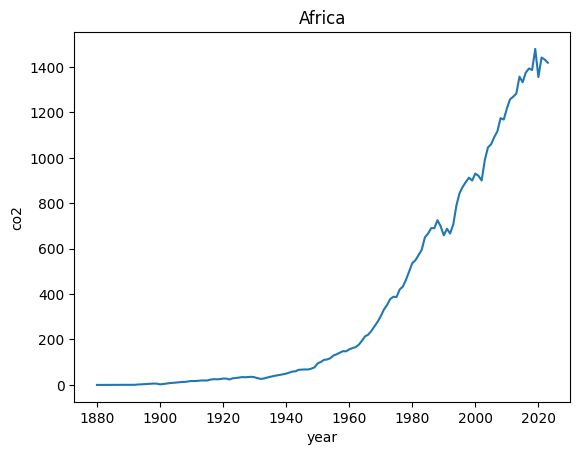

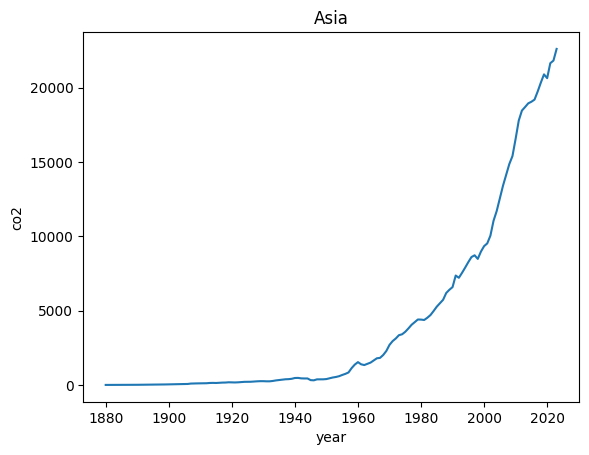

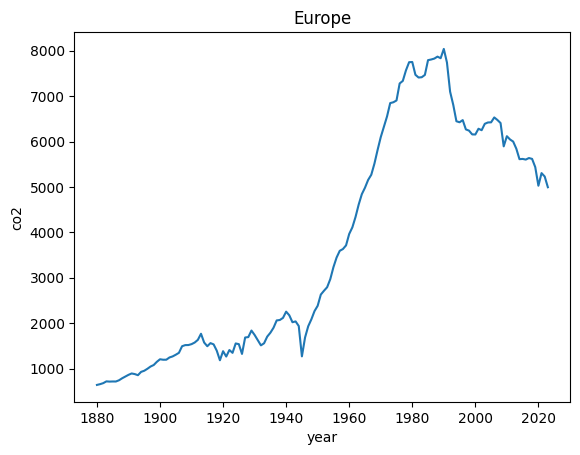

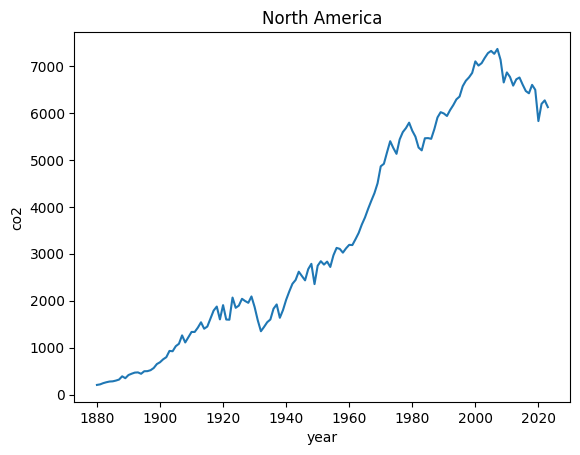

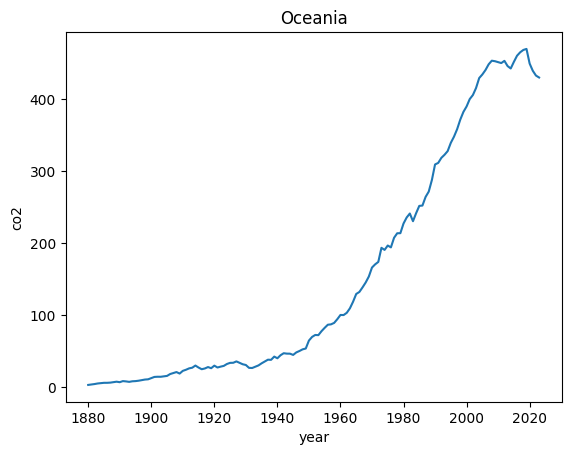

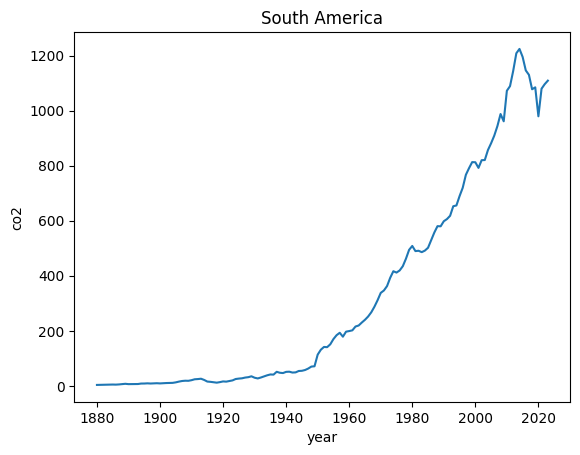

In [ ]:
#verif des emissions de co2 par continent

for country in owid_continents_1880['country'].unique():
  df_tmp = owid_continents_1880[owid_continents_1880['country']==country]
  sns.lineplot(data=df_tmp, x='year', y='co2')
  plt.title(country)
  plt.show();

In [ ]:
#calcul des colonnes per_capita
owid_continents_1880 = compute_per_capita_cols(owid_continents_1880)

In [ ]:
print_nan_per_countries(owid_continents_1880)

================= Africa
co2_growth_abs                                 5
co2_growth_prct                                5
co2_including_luc_growth_abs                   5
co2_including_luc_growth_prct                  5
cumulative_co2                                 4
cumulative_co2_including_luc                   4
cumulative_coal_co2                            4
cumulative_flaring_co2                        69
cumulative_gas_co2                             4
cumulative_oil_co2                             4
cumulative_other_co2                         144
share_global_co2                               4
share_global_co2_including_luc                 4
share_global_coal_co2                          4
share_global_cumulative_co2                    4
share_global_cumulative_co2_including_luc      4
share_global_cumulative_coal_co2               4
share_global_cumulative_flaring_co2           70
share_global_cumulative_gas_co2                4
share_global_cumulative_oil_co2             

In [ ]:
#Petit test de cumsum() pour voir si on a les mêmes données que la colonne cumulative déjà fournie
df_tmp = owid_continents_1880.loc[owid_continents_1880['country']=='Europe', ['year','co2', 'cumulative_co2']]

df_tmp['cumulative_co2_bis'] = df_tmp['co2'].cumsum()
df_tmp['cumulative_co2'] = df_tmp['cumulative_co2'] - df_tmp['cumulative_co2'].iloc[0] + df_tmp['co2'].iloc[0]
df_tmp

,year,co2,cumulative_co2,cumulative_co2_bis
378,1880,640.736,640.736,640.736
379,1881,657.769,1298.506,1298.505
380,1882,680.193,1978.698,1978.698
381,1883,718.760,2697.459,2697.458
382,1884,714.138,3411.598,3411.596
...,...,...,...,...
517,2019,5436.906,512424.999,512424.972
518,2020,5026.315,517451.311,517451.287
519,2021,5304.040,522755.311,522755.327
520,2022,5228.870,527984.186,527984.197


In [ ]:
#tests pour récupérer une colonne disant si on a des nan pour cumulative_co2
val = owid_continents_1880['cumulative_co2'].iloc[0]
print(val, " is nan ? ", np.isnan(val))

df_copy = owid_continents_1880.copy()
df_copy['cumulative_co2_nan'] = df_copy.apply(lambda row : 1 if np.isnan(row['cumulative_co2']) else 0, axis=1)

df_copy[['cumulative_co2', 'cumulative_co2_nan']]

nan  is nan ?  True


,cumulative_co2,cumulative_co2_nan
30,NaN,1
31,NaN,1
32,NaN,1
33,NaN,1
34,0.022,0
...,...,...
1039,42083.832,0
1040,43063.270,0
1041,44143.004,0
1042,45239.156,0


In [ ]:
#reset et fill na des cumuls
owid_continents_1880 = reset_cumul(owid_continents_1880)
print_nan_per_countries(owid_continents_1880)

================= Africa
co2_growth_abs                                 5
co2_growth_prct                                5
co2_including_luc_growth_abs                   5
co2_including_luc_growth_prct                  5
share_global_co2                               4
share_global_co2_including_luc                 4
share_global_coal_co2                          4
share_global_cumulative_co2                    4
share_global_cumulative_co2_including_luc      4
share_global_cumulative_coal_co2               4
share_global_cumulative_flaring_co2           70
share_global_cumulative_gas_co2                4
share_global_cumulative_oil_co2                4
share_global_cumulative_other_co2            144
share_global_flaring_co2                      70
share_global_gas_co2                           4
share_global_oil_co2                           4
share_global_other_co2                       144
dtype: int64
nb lignes = 144
================= Asia
share_global_cumulative_flaring_co2     7

On doit s'occuper des growth_abs et prct qui sont nan chez Africa.
ça correspond à des lignes où co2 et co2_including_luc sont vides donc les growth valent 0.

In [ ]:
owid_continents_1880.loc[owid_continents_1880['country']=='Africa',
 ['co2_growth_abs', 'co2_growth_prct', 'co2_including_luc_growth_abs', 'co2_including_luc_growth_prct']] = owid_continents_1880.loc[owid_continents_1880['country']=='Africa',
  ['co2_growth_abs', 'co2_growth_prct','co2_including_luc_growth_abs', 'co2_including_luc_growth_prct']].fillna(0)


owid_continents_1880.loc[owid_continents_1880['country']=='Africa', ['co2', 'co2_growth_abs', 'co2_growth_prct',
                                                                     'co2_including_luc', 'co2_including_luc_growth_abs', 'co2_including_luc_growth_prct']]

,co2,co2_growth_abs,co2_growth_prct,co2_including_luc,co2_including_luc_growth_abs,co2_including_luc_growth_prct
30,0.000,0.000,0.000,0.000,0.000,0.000
31,0.000,0.000,0.000,0.000,0.000,0.000
32,0.000,0.000,0.000,0.000,0.000,0.000
33,0.000,0.000,0.000,0.000,0.000,0.000
34,0.022,0.000,0.000,16.946,0.000,0.000
...,...,...,...,...,...,...
169,1479.412,92.758,6.689,2826.805,-38.507,-1.344
170,1355.782,-123.629,-8.357,2568.785,-258.019,-9.128
171,1441.534,85.752,6.325,2691.579,122.794,4.780
172,1432.503,-9.031,-0.626,2719.051,27.472,1.021


In [ ]:
print_nan_per_countries(owid_continents_1880)

================= Africa
share_global_co2                               4
share_global_co2_including_luc                 4
share_global_coal_co2                          4
share_global_cumulative_co2                    4
share_global_cumulative_co2_including_luc      4
share_global_cumulative_coal_co2               4
share_global_cumulative_flaring_co2           70
share_global_cumulative_gas_co2                4
share_global_cumulative_oil_co2                4
share_global_cumulative_other_co2            144
share_global_flaring_co2                      70
share_global_gas_co2                           4
share_global_oil_co2                           4
share_global_other_co2                       144
dtype: int64
nb lignes = 144
================= Asia
share_global_cumulative_flaring_co2     70
share_global_cumulative_gas_co2          2
share_global_cumulative_other_co2      110
share_global_flaring_co2                70
share_global_gas_co2                     2
share_global_other_co2

#Il ne reste plus que les Share à traiter, pour cela on va devoir comparer au csv world

In [ ]:
owid_world = pd.read_csv('drive/MyDrive/Projet Mar25 DA - DataScientest/Cleaned CSV/owid_ghg_world.csv')
owid_world.head()

,year,population,gdp,cement_co2,cement_co2_per_capita,co2,co2_growth_abs,co2_growth_prct,co2_including_luc,co2_including_luc_growth_abs,...,oil_co2,oil_co2_per_capita,other_co2_per_capita,other_industry_co2,temperature_change_from_ch4,temperature_change_from_co2,temperature_change_from_ghg,temperature_change_from_n2o,total_ghg,total_ghg_excluding_lucf
0,1850,1287033856,1.546684e+12,0.0,0.0,196.848,11.800,6.376,2835.459,0.000,...,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,4219.061,681.081
1,1851,1294571381,1.561941e+12,0.0,0.0,198.779,1.931,0.981,3018.492,183.033,...,0.0,0.0,0.0,0.0,0.000,0.001,0.002,0.0,4409.311,684.198
2,1852,1301972716,1.577382e+12,0.0,0.0,207.595,8.817,4.435,3065.094,46.601,...,0.0,0.0,0.0,0.0,0.001,0.003,0.004,0.0,4465.078,696.189
3,1853,1309237862,1.593009e+12,0.0,0.0,217.237,9.642,4.645,3122.835,57.741,...,0.0,0.0,0.0,0.0,0.001,0.004,0.006,0.0,4532.813,709.859
4,1854,1316366818,1.608820e+12,0.0,0.0,255.039,37.802,17.401,3169.879,47.044,...,0.0,0.0,0.0,0.0,0.002,0.006,0.008,0.0,4594.583,756.674


In [ ]:

df_copy = owid_continents_1880.copy()
#on calcul les colonnes share
df_copy = compute_share(df_copy, owid_world)

cols_share = []
for c in df_copy.columns:
  if 'share' in c:
    cols_share.append(c)

owid_continents_1880.loc[:, cols_share] = owid_continents_1880[cols_share].fillna(df_copy[cols_share])

print_nan_per_countries(owid_continents_1880)

================= Africa
Series([], dtype: float64)
nb lignes = 144
================= Asia
Series([], dtype: float64)
nb lignes = 144
================= Europe
Series([], dtype: float64)
nb lignes = 144
================= North America
Series([], dtype: float64)
nb lignes = 144
================= Oceania
Series([], dtype: float64)
nb lignes = 144
================= South America
Series([], dtype: float64)
nb lignes = 144


In [ ]:
for col in cols_share:
  plt.figure(figsize=(10,10))
  plt.title(col)
  for country in owid_continents_1880['country'].unique():
      sns.lineplot(data=owid_continents_1880[owid_continents_1880['country']==country], x='year', y=col, label=country)
  plt.legend()
  plt.show();

Output hidden; open in https://colab.research.google.com to view.

Les données de share ont l'air assez cohérentes : quand la part d'un continent augmente, les parts des autres diminuent (logique car il s'agit d'une proportion du continent à l'échelle mondiale).

In [ ]:
#creation du csv après 1880 - Cleaned
owid_continents_1880.to_csv('drive/MyDrive/Projet Mar25 DA - DataScientest/Cleaned CSV/owid_co2_continents_1880.csv', index=False)

# Clean du CSV des pays (iso)

In [ ]:
owid_iso = pd.read_csv('drive/MyDrive/Projet Mar25 DA - DataScientest/WIP CSV/owid_co2_iso.csv')
owid_iso.head()

,country,year,iso_code,population,gdp,cement_co2,cement_co2_per_capita,co2,co2_growth_abs,co2_growth_prct,...,share_global_other_co2,share_of_temperature_change_from_ghg,temperature_change_from_ch4,temperature_change_from_co2,temperature_change_from_ghg,temperature_change_from_n2o,total_ghg,total_ghg_excluding_lucf,trade_co2,trade_co2_share
0,Afghanistan,1750,AFG,2802560.0,NaN,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,1751,AFG,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,1752,AFG,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,1753,AFG,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,1754,AFG,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


interpolation population

In [ ]:

#interpolate population par pays
owid_iso = interpolate_population(owid_iso)
country_with_nan = owid_iso.loc[df['population'].isna(), 'country'].unique()
#affichage pays avec population NaN
for country in country_with_nan:
  print("=================", country)
  df_tmp = owid_iso[owid_iso['country']==country]
  years_na = df_tmp.loc[df_tmp['population'].isna(),'year']
  print("min year na = ", years_na.min())
  print("max year na = " , years_na.max())
  print("nb na = ", str(len(years_na)))
  print("diff max-min = ", (years_na.max()- years_na.min()+1))

================= Antarctica
min year na =  1750
max year na =  2023
nb na =  274
diff max-min =  274
================= Bonaire Sint Eustatius and Saba
min year na =  1851
max year na =  1949
nb na =  99
diff max-min =  99
================= British Virgin Islands
min year na =  1850
max year na =  1870
nb na =  21
diff max-min =  21
================= Canada
min year na =  1785
max year na =  1789
nb na =  5
diff max-min =  5
================= Christmas Island
min year na =  1851
max year na =  2023
nb na =  173
diff max-min =  173
================= Curacao
min year na =  1851
max year na =  1949
nb na =  99
diff max-min =  99
================= Faroe Islands
min year na =  1851
max year na =  1859
nb na =  9
diff max-min =  9
================= French Polynesia
min year na =  1851
max year na =  1899
nb na =  49
diff max-min =  49
================= Germany
min year na =  1792
max year na =  1799
nb na =  8
diff max-min =  8
================= Macao
min year na =  1750
max year na =  1799


In [ ]:
#pour les pays on peut se contenter des infos après 1950, cela nous retire une épine du pied en matière de NaN
owid_iso_1950 = owid_iso[owid_iso['year']>=1950]

country_with_nan = owid_iso_1950.loc[df['population'].isna(), 'country'].unique()
#affichage pays avec population NaN
for country in country_with_nan:
  print("=================", country)
  df_tmp = owid_iso_1950[owid_iso_1950['country']==country]
  years_na = df_tmp.loc[df_tmp['population'].isna(),'year']
  print("min year na = ", years_na.min())
  print("max year na = " , years_na.max())
  print("nb na = ", str(len(years_na)))
  print("diff max-min = ", (years_na.max()- years_na.min()+1))

================= Antarctica
min year na =  1950
max year na =  2023
nb na =  74
diff max-min =  74
================= Christmas Island
min year na =  1950
max year na =  2023
nb na =  74
diff max-min =  74


In [ ]:
#suppression de christmas island car aucune valeur pertinente

owid_iso_1950 = owid_iso_1950[owid_iso_1950['country']!='Christmas Island']

In [ ]:
#recherche valeur pertinente antartica
df_tmp = owid_iso_1950.loc[owid_iso_1950['country']=='Antarctica', ['country', 'year', 'iso_code', 'cement_co2', 'cumulative_cement_co2',
       'share_global_cement_co2', 'share_global_cumulative_cement_co2',
       'share_of_temperature_change_from_ghg', 'temperature_change_from_co2',
       'temperature_change_from_ghg']]
df_tmp.isna().sum(axis=0)

df_tmp.tail(50)

,country,year,iso_code,cement_co2,cumulative_cement_co2,share_global_cement_co2,share_global_cumulative_cement_co2,share_of_temperature_change_from_ghg,temperature_change_from_co2,temperature_change_from_ghg
1468,Antarctica,1974,ATA,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1469,Antarctica,1975,ATA,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1470,Antarctica,1976,ATA,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1471,Antarctica,1977,ATA,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1472,Antarctica,1978,ATA,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1473,Antarctica,1979,ATA,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1474,Antarctica,1980,ATA,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1475,Antarctica,1981,ATA,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1476,Antarctica,1982,ATA,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1477,Antarctica,1983,ATA,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#suppression de Antarctica car aucune valeur pertinente
owid_iso_1950 = owid_iso_1950[owid_iso_1950['country']!='Antarctica']


owid_iso_1950.columns[owid_iso_1950.isna().any(axis = 0)]

Index(['gdp', 'cement_co2', 'cement_co2_per_capita', 'co2', 'co2_growth_abs',
       'co2_growth_prct', 'co2_including_luc', 'co2_including_luc_growth_abs',
       'co2_including_luc_growth_prct', 'co2_including_luc_per_capita',
       'co2_including_luc_per_gdp', 'co2_including_luc_per_unit_energy',
       'co2_per_capita', 'co2_per_gdp', 'co2_per_unit_energy', 'coal_co2',
       'coal_co2_per_capita', 'consumption_co2', 'consumption_co2_per_capita',
       'consumption_co2_per_gdp', 'cumulative_cement_co2', 'cumulative_co2',
       'cumulative_co2_including_luc', 'cumulative_coal_co2',
       'cumulative_flaring_co2', 'cumulative_gas_co2', 'cumulative_luc_co2',
       'cumulative_oil_co2', 'cumulative_other_co2', 'energy_per_capita',
       'energy_per_gdp', 'flaring_co2', 'flaring_co2_per_capita', 'gas_co2',
       'gas_co2_per_capita', 'ghg_excluding_lucf_per_capita', 'ghg_per_capita',
       'land_use_change_co2', 'land_use_change_co2_per_capita', 'methane',
       'methane_per_ca

In [ ]:
#remplace emissions co2 nan par 0
owid_iso_1950 = fillna_co2_emissions(owid_iso_1950)

In [ ]:
#calcul gdp manquant
owid_iso_1950 = interpolate_gdp(owid_iso_1950)

/usr/local/lib/python3.11/dist-packages/pandas/core/missing.py:604: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  terp = interpolate.UnivariateSpline(x, y, k=order, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/missing.py:604: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  terp = interpolate.UnivariateSpline(x, y, k=order, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/missing.py:604: UserWarning: 
The maximal number of iterations maxit (set to 20 by t

In [ ]:
country_with_nan = owid_iso_1950.loc[owid_iso_1950['gdp'].isna(), 'country'].unique()
#affichage pays avec gdp NaN
for country in country_with_nan:
  print("=================", country)
  df_tmp = owid_iso_1950[owid_iso_1950['country']==country]
  years_na = df_tmp.loc[df_tmp['gdp'].isna(),'year']
  print("min year na = ", years_na.min())
  print("max year na = " , years_na.max())
  print("nb na = ", str(len(years_na)))
  print("diff max-min = ", (years_na.max()- years_na.min()+1))

================= Andorra
min year na =  1950
max year na =  2023
nb na =  74
diff max-min =  74
================= Anguilla
min year na =  1950
max year na =  2023
nb na =  74
diff max-min =  74
================= Antigua and Barbuda
min year na =  1950
max year na =  2023
nb na =  74
diff max-min =  74
================= Armenia
min year na =  1950
max year na =  1972
nb na =  23
diff max-min =  23
================= Aruba
min year na =  1950
max year na =  2023
nb na =  74
diff max-min =  74
================= Azerbaijan
min year na =  1950
max year na =  1972
nb na =  23
diff max-min =  23
================= Bahamas
min year na =  1950
max year na =  2023
nb na =  74
diff max-min =  74
================= Belarus
min year na =  1950
max year na =  1972
nb na =  23
diff max-min =  23
================= Belize
min year na =  1950
max year na =  2023
nb na =  74
diff max-min =  74
================= Bermuda
min year na =  1950
max year na =  2023
nb na =  74
diff max-min =  74
=================

In [ ]:
#calcul colonnes par population
owid_iso_1950 = compute_per_capita_cols(owid_iso_1950)

In [ ]:
#calcul des colonnes de cumul
owid_iso_1950 = reset_cumul(owid_iso_1950)

In [ ]:
#calcul des colonnes Share
owid_iso_1950 = compute_share(owid_iso_1950, owid_world)

could not compute columnn : trade_co2_share
trade_co2  in df : True
trade_co2  in df_world : False
could not compute columnn : trade_co2_share
trade_co2  in df : True
trade_co2  in df_world : False
could not compute columnn : trade_co2_share
trade_co2  in df : True
trade_co2  in df_world : False
could not compute columnn : trade_co2_share
trade_co2  in df : True
trade_co2  in df_world : False
could not compute columnn : trade_co2_share
trade_co2  in df : True
trade_co2  in df_world : False
could not compute columnn : trade_co2_share
trade_co2  in df : True
trade_co2  in df_world : False
could not compute columnn : trade_co2_share
trade_co2  in df : True
trade_co2  in df_world : False
could not compute columnn : trade_co2_share
trade_co2  in df : True
trade_co2  in df_world : False
could not compute columnn : trade_co2_share
trade_co2  in df : True
trade_co2  in df_world : False
could not compute columnn : trade_co2_share
trade_co2  in df : True
trade_co2  in df_world : False
could not 

In [ ]:
#check des NaN après tout ces cleans
df_na = owid_iso_1950.isnull().sum(axis = 0)

df_na[df_na>0]

,0
gdp,4055
co2_growth_abs,888
co2_growth_prct,901
co2_including_luc_growth_abs,2097
co2_including_luc_growth_prct,2097
energy_per_capita,6358
energy_per_gdp,8079
ghg_excluding_lucf_per_capita,1332
ghg_per_capita,1258
methane,1258


In [ ]:
#Voyons où temperature_change_from ghg est null
owid_iso_1950.loc[owid_iso_1950['temperature_change_from_ghg'].isna(), 'country'].unique()

array(['Monaco', 'San Marino', 'Vatican'], dtype=object)

In [ ]:
#remove Monaco, San Marino et Vatican

owid_iso_1950 = owid_iso_1950[~owid_iso_1950['country'].isin(['Monaco', 'San Marino', 'Vatican'])]

In [ ]:
df_na = owid_iso_1950.isnull().sum(axis = 0)

df_na[df_na>0]

,0
gdp,4055
co2_growth_abs,888
co2_growth_prct,901
co2_including_luc_growth_abs,2097
co2_including_luc_growth_prct,2097
energy_per_capita,6358
energy_per_gdp,8079
ghg_excluding_lucf_per_capita,1332
ghg_per_capita,1258
methane,1258


In [ ]:
country_with_nan = owid_iso_1950.loc[owid_iso_1950['gdp'].isna(), 'country'].unique()
#affichage pays avec gdp NaN
countries_full_nan_gdp = []
for country in country_with_nan:
  df_tmp = owid_iso_1950[owid_iso_1950['country']==country]
  years_na = df_tmp.loc[df_tmp['gdp'].isna(),'year']
  if len(years_na) == len(df_tmp):
    countries_full_nan_gdp.append(country)

print(countries_full_nan_gdp)

#on supprime les pays ayant 0 donnée de PIB

owid_iso_1950 = owid_iso_1950[~owid_iso_1950['country'].isin(countries_full_nan_gdp)]

['Andorra', 'Anguilla', 'Antigua and Barbuda', 'Aruba', 'Bahamas', 'Belize', 'Bermuda', 'Bhutan', 'Bonaire Sint Eustatius and Saba', 'British Virgin Islands', 'Brunei', 'Cook Islands', 'Curacao', 'East Timor', 'Eritrea', 'Faroe Islands', 'Fiji', 'French Polynesia', 'Greenland', 'Grenada', 'Guyana', 'Kiribati', 'Liechtenstein', 'Macao', 'Maldives', 'Marshall Islands', 'Micronesia (country)', 'Montserrat', 'Nauru', 'New Caledonia', 'Niue', 'Palau', 'Papua New Guinea', 'Saint Helena', 'Saint Kitts and Nevis', 'Saint Pierre and Miquelon', 'Saint Vincent and the Grenadines', 'Samoa', 'Sint Maarten (Dutch part)', 'Solomon Islands', 'Somalia', 'South Sudan', 'Sudan', 'Suriname', 'Tonga', 'Turks and Caicos Islands', 'Tuvalu', 'Vanuatu', 'Wallis and Futuna']


In [ ]:
#suppression des colonnes energy par pays
cols_energy = []

for c in owid_iso_1950.columns:
  if 'energy' in c:
    cols_energy.append(c)

owid_iso_1950 = owid_iso_1950.drop(columns=cols_energy)

In [ ]:
#enregistrement du owid_iso_1950 pour sauvegarder le travail effectué jusqu'ici

owid_iso_1950.to_csv('drive/MyDrive/Projet Mar25 DA - DataScientest/WIP CSV/owid_co2_iso_1950.csv', index=False)

Par manque de temps, je ne suis pas allé plus loin dans le nettoyage du csv ISO.
Mon analyse se portera sur le monde et les continents.

Il y a beaucoup de cas particuliers pour le csv ISO, on trouve toujours quelques pays qui n'ont pas de données ici et là, ce qui rend le nettoyage chronophage.